# Takahashi Model Emulation (Python Implementation)

<p style="color:crimson;"> *To start using this notebook, please press the double <code>>></code> button.* </p> 

In [1]:
import numpy as np
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import *
from scipy.interpolate import make_interp_spline, interp2d
%matplotlib notebook
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import pandas as pd

In [2]:
#List of constant values.
surface_area = 0.005 
valence = 3
I = 20
F = 96485
V = 0.00125

class Elements:
    
    def __init__(self, stab, K_hydro, diff_coeff):
        self.stab = stab
        self.K_hydro = K_hydro
        self.diff_coeff = diff_coeff
        
La_EDTA = Elements(np.power(10, 15.50), 1.49, 4.4e13)
Pr_EDTA = Elements(np.power(10, 16.40), 1.40, 4.8e13)
Nd_EDTA = Elements(np.power(10, 16.61), 1.15, 5.2e13)
Gd_EDTA = Elements(np.power(10, 17.37), 0.91, 6.5e13)
Y_EDTA = Elements(np.power(10, 18.09), 0.66, 1.1e14)

La_DCTA = Elements(np.power(10, 16.60), 1.49, 4.4e13)
Pr_DCTA = Elements(np.power(10, 17.01), 1.40, 4.8e13)
Nd_DCTA = Elements(np.power(10, 17.31), 1.15, 5.2e13)
Gd_DCTA = Elements(np.power(10, 18.70), 0.91, 6.5e13)
Y_DCTA = Elements(np.power(10, 19.60), 0.66, 1.1e14)

La_HEDTA = Elements(np.power(10, 13.22), 1.49, 4.4e13)
Pr_HEDTA = Elements(np.power(10, 14.39), 1.40, 4.8e13)
Nd_HEDTA = Elements(np.power(10, 14.71), 1.15, 5.2e13)
Gd_HEDTA = Elements(np.power(10, 15.10), 0.91, 6.5e13)
Y_HEDTA = Elements(np.power(10, 14.49), 0.66, 1.1e14)


k_edta = [np.power(10, -2.00), np.power(10, -2.67),
          np.power(10, -6.16), np.power(10, -10.26)]

k_dcta = [np.power(10, -2.40), np.power(10, -3.55),
          np.power(10, -6.14), np.power(10, -11.70)]

k_hedta = [np.power(10, -3.23), np.power(10, -5.50),
           np.power(10, -10.02)]


In [3]:
init_conds = ['La', 'Nd', 'EDTA', 10.0, 10.0, 5.0, 1.0, 30000, 30, 0.5, 9.5, 1.0, 17.0, 13.0, 2.0, 1.25, \
              'Changing', 'odeint', 'No']

LREE_type = widgets.Dropdown(options=['La', 'Pr', 'Nd', 'Gd', 'Y'],
                        value='La',
                        description='LREE')

HREE_type = widgets.Dropdown(options=['Pr', 'Nd', 'Gd', 'Y'],
                        value='Y',
                        description='HREE')

agent_type = widgets.Dropdown(options=['EDTA', 'HEDTA', 'DCTA'],
                         value='EDTA',
                         description='Chelant:')


light = widgets.FloatSlider(value=5.0, min=0, max=50.0, description=('$[LREE]$'))

heavy = widgets.FloatSlider(value=5.0, min=0, max=50.0, description=('$[HREE]$'))

agent = widgets.FloatSlider(value=5.0, min=0, max=100.0, description=('$[Chelant]$'))

H = widgets.FloatSlider(value=1.0, min=0, max=10, description='$[H]$')

time = widgets.FloatSlider(value=10800, min=0, max=60000, description='Time (s)')

capacity = widgets.FloatSlider(value=10.78, min=0, max=100.0, description ='Q $(mol/m^3)$', \
                               style={'description_width': 'initial'})

guess_1a = widgets.IntSlider(value=1.0, min=0, max=10.0, description='$[LREE-Complex]$', \
                             style={'description_width': 'initial'})

guess_1b = widgets.IntSlider(value=9.5, min=0, max=10.0, description='$[HREE-Complex]$', \
                             style={'description_width': 'initial'})

guess_1c = widgets.IntSlider(value=1.0, min=0, max=10.0, description='$[No~Complex]$', \
                             style={'description_width': 'initial'})

guess_2a = widgets.IntSlider(value=17.0, min=0, max=30.0, description='$[Membrane~LREE~Ion]$', \
                             style={'description_width': 'initial'})

guess_2b = widgets.IntSlider(value=13.0, min=0, max=30.0, description='$[Membrane~HREE~Ion]$', \
                             style={'description_width': 'initial'})

guess_2c = widgets.IntSlider(value=2.0, min=0, max=30.0, description='$[Membrane~Chelant]$', \
                             style={'description_width': 'initial'})

guess_2d = widgets.IntSlider(value=1.25, min=0, max=30.0, description='$[Membrane~H]$', \
                             style={'description_width': 'initial'}, tooltips='hello')

delta_H = widgets.ToggleButtons(
    options=['Changing', 'Not Changing'],
    description='$[H]$',
    disabled=False,
    button_style='info', 
    tooltips=['Concentration of H is changing over time', 'Concentration of H is not changing over time'],
    icons=['check']*2)

ode_solver = widgets.ToggleButtons(
    options=['odeint', 'solve_ivp'],
    description='Type of ODE Solver: ',
    disabled=False,
    button_style='danger',
    tooltips=['Simple solver of ordinary differential equations', 'Solves ODEs as initial value problem, RK45'],
    icons=['check']*2,
    style={'description_width': 'initial'})

interp = widgets.ToggleButtons(
    options=['No', 'Yes'],
    description='Interpolation ',
    disabled=True,
    button_style='warning',
    tooltips=['Do not display 2-D interpolation model', 'Display 2-D interpolation model'],
    icons=['check']*2,
    style={'description_width': 'initial'})

print('Please input initial values: ')


def conditions(LREE_type, HREE_type, agent_type, light, heavy, agent, H, time, capacity, \
               guess_1a, guess_1b, guess_1c, guess_2a, guess_2b, guess_2c, guess_2d, delta_H, ode_solver, interp):
    
    '''
    Conditions(LREE_type, .., capacity) produces the separation factor and plot for a binary separation.
    
    It is attempting to replicate the Takahashi model. Proceeds to solve equations 2-6 and 7-9 via fsolve.
    Employs odeint/solve_ivp for the differential equations.
    '''
    
    init_conds[0] = LREE_type
    init_conds[1] = HREE_type
    init_conds[2] = agent_type
    init_conds[3] = light
    init_conds[4] = heavy
    init_conds[5] = agent
    init_conds[6] = H
    init_conds[7] = time
    init_conds[8] = capacity
    init_conds[9] = guess_1a
    init_conds[10] = guess_1b
    init_conds[11] = guess_1c
    init_conds[12] = guess_2a
    init_conds[13] = guess_2b
    init_conds[14] = guess_2c
    init_conds[15] = guess_2d
    init_conds[16] = delta_H
    init_conds[17] = ode_solver
    init_conds[18] = interp
    
    if (init_conds[0] == 'La') and (init_conds[1] == 'Pr'):
        if (init_conds[2] == 'EDTA'):
            light = La_EDTA
            heavy = Pr_EDTA
        elif (init_conds[2] == 'DCTA'):
            light = La_DCTA
            heavy = Pr_DCTA
        elif (init_conds[2] == 'HEDTA'):
            light = La_HEDTA
            heavy = Pr_HEDTA
    
    elif (init_conds[0] == 'La') and (init_conds[1] == 'Nd'):
        if (init_conds[2] == 'EDTA'):
            light = La_EDTA
            heavy = Nd_EDTA
        elif (init_conds[2] == 'DCTA'):
            light = La_DCTA
            heavy = Nd_DCTA
        elif (init_conds[2] == 'HEDTA'):
            light = La_HEDTA
            heavy = Nd_HEDTA
        
        
    elif (init_conds[0] == 'La') and (init_conds[1] == 'Gd'):
        if (init_conds[2] == 'EDTA'):
            light = La_EDTA
            heavy = Gd_EDTA
        elif (init_conds[2] == 'DCTA'):
            light = La_DCTA
            heavy = Gd_DCTA
        elif (init_conds[2] == 'HEDTA'):
            light = La_HEDTA
            heavy = Gd_HEDTA
        
    elif (init_conds[0] == 'La') and (init_conds[1] == 'Y'):
        if (init_conds[2] == 'EDTA'):
            light = La_EDTA
            heavy = Y_EDTA
        elif (init_conds[2] == 'DCTA'):
            light = La_DCTA
            heavy = Y_DCTA
        elif (init_conds[2] == 'HEDTA'):
            light = La_HEDTA
            heavy = Y_HEDTA
    
    elif (init_conds[0] == 'Pr') and (init_conds[1] == 'Nd'):
        if (init_conds[2] == 'EDTA'):
            light = Pr_EDTA
            heavy = Nd_EDTA
        elif (init_conds[2] == 'DCTA'):
            light = Pr_DCTA
            heavy = Nd_DCTA
        elif (init_conds[2] == 'HEDTA'):
            light = Pr_HEDTA
            heavy = Nd_HEDTA
        
    elif (init_conds[0] == 'Pr') and (init_conds[1] == 'Gd'):
        if (init_conds[2] == 'EDTA'):
            light = Pr_EDTA
            heavy = Gd_EDTA
        elif (init_conds[2] == 'DCTA'):
            light = Pr_DCTA
            heavy = Gd_DCTA
        elif (init_conds[2] == 'HEDTA'):
            light = Pr_HEDTA
            heavy = Gd_HEDTA
        
    elif (init_conds[0] == 'Pr') and (init_conds[1] == 'Y'):
        if (init_conds[2] == 'EDTA'):
            light = Pr_EDTA
            heavy = Y_EDTA
        elif (init_conds[2] == 'DCTA'):
            light = Pr_DCTA
            heavy = Y_DCTA
        elif (init_conds[2] == 'HEDTA'):
            light = Pr_HEDTA
            heavy = Y_HEDTA
                                     
    elif (init_conds[0] == 'Nd') and (init_conds[1] == 'Gd'):
        if (init_conds[2] == 'EDTA'):
            light = Nd_EDTA
            heavy = Gd_EDTA
        elif (init_conds[2] == 'DCTA'):
            light = Nd_DCTA
            heavy = Gd_DCTA
        elif (init_conds[2] == 'HEDTA'):
            light = Nd_HEDTA
            heavy = Gd_HEDTA
            
    elif (init_conds[0] == 'Nd') and (init_conds[1] == 'Y'):
        if (init_conds[2] == 'EDTA'):
            light = Nd_EDTA
            heavy = Y_EDTA
        elif (init_conds[2] == 'DCTA'):
            light = Nd_DCTA
            heavy = Y_DCTA
        elif (init_conds[2] == 'HEDTA'):
            light = Nd_HEDTA
            heavy = Y_HEDTA
        
    elif (init_conds[0] == 'Gd') and (init_conds[1] == 'Y'):
        if (init_conds[2] == 'EDTA'):
            light = Gd_EDTA
            heavy = Y_EDTA
        elif (init_conds[2] == 'DCTA'):
            light = Gd_DCTA
            heavy = Y_DCTA
        elif (init_conds[2] == 'HEDTA'):
            light = Gd_HEDTA
            heavy = Y_HEDTA
        
    else:
        return ['Retry']
    
    if (init_conds[2] == 'EDTA') or (init_conds[2] == 'DCTA'):
        
        if init_conds[2] == 'EDTA':
            k1 = k_edta[0]
            k2 = k_edta[1]
            k3 = k_edta[2]
            k4 = k_edta[3]
            
            alpha = (k1*k2*k3*k4)/(k1*k2*k3*k4 + \
                                   k1*k2*k3*init_conds[6] + \
                                   k1*k2*np.power(init_conds[6], 2) + \
                                   k1*np.power(init_conds[6], 3) + \
                                   np.power(init_conds[6], 4))
            
        else:
            
            k1 = k_dcta[0]
            k2 = k_dcta[1]
            k3 = k_dcta[2]
            k4 = k_dcta[3]
            
            alpha = (k1*k2*k3*k4)/(k1*k2*k3*k4 + \
                                   k1*k2*k3*init_conds[6] + \
                                   k1*k2*np.power(init_conds[6], 2) + \
                                   k1*np.power(init_conds[6], 3) + \
                                   np.power(init_conds[6], 4))
    
    elif (init_conds[2] == 'HEDTA'):
        
        alpha = (k_hedta[0]*k_hedta[1]*k_hedta[2])/   \
                (k_hedta[0]*k_hedta[1]*k_hedta[2] +   \
                 k_hedta[0]*k_hedta[1]*init_conds[6]      +   \
                 k_hedta[0]*np.power(init_conds[6], 2)    +   \
                 np.power(init_conds[6], 3))
        
        

    
    def eq_26(guess_26):
        
        light_complex = guess_26[0]
        heavy_complex = guess_26[1]
        no_complex = guess_26[2]
        
        eq_26_sol = np.zeros(3)
        
        eq_26_sol[0] = init_conds[3] - (light_complex / (light.stab * alpha * no_complex) + light_complex)
        eq_26_sol[1] = init_conds[4] - (heavy_complex / (heavy.stab * alpha * no_complex) + heavy_complex)
        eq_26_sol[2] = init_conds[5] - (light_complex + heavy_complex + no_complex)
        
        return eq_26_sol
    
    #guess = np.array([0.5,9.5,1])
    #guess2 = np.array([1,1,1])
    
    guess_1 = np.array([init_conds[9], init_conds[10], init_conds[11]])
                        
    te_sol = fsolve(eq_26, guess_1)
    
    #print('Concentration of LaEDTA =', te_sol[0])
    #print('Concentration of NdEDTA ion =', te_sol[1])
    #print('Concentration of EDTA non-complex =', te_sol[2])
    #print('solution: ', te_sol, '\n', 'equations:', eq_26(te_sol))
    
    light_computed = te_sol[0]/(light.stab*(alpha*te_sol[2]))
    heavy_computed = te_sol[1]/(heavy.stab*(alpha*te_sol[2]))
    
    def eq_79 (mem_guess):
        
        light_mem = mem_guess[0]
        heavy_mem = mem_guess[1]
        Na_mem = mem_guess[2]
        H_mem = mem_guess[3]
        
        compute_79 = np.zeros(4)
        
        compute_79[0] = light_mem - (light.K_hydro * \
                                     np.power(H_mem, 3) * \
                                     (light_computed/(np.power(init_conds[6],3))) ** 0.8)
        
        compute_79[1] = heavy_mem - (heavy.K_hydro * \
                                     np.power(H_mem, 3) * \
                                     (heavy_computed/(np.power(init_conds[6],3))) ** 0.8)
        
        compute_79[2] = Na_mem - (0.32 * H_mem * (init_conds[5]/init_conds[6]))
        
        compute_79[3] = init_conds[8] - (3 * (light_mem+heavy_mem) + Na_mem + H_mem)
        
        return compute_79
    
    #sample_guess3 = np.array([light_computed*1.7, heavy_computed*1.3, init_conds[5]*1.25, init_conds[6]*4])
    #sample_guess3 = np.array([1,1,1,1])
    guess_2 = np.array([init_conds[12], init_conds[13], init_conds[14], init_conds[15]])

    eq_79_sol = fsolve(eq_79, guess_2)

    #print('Concentration of La in membrane=', eq_79_sol[0])
    #print('Concentration of Nd in membrane=', eq_79_sol[1])
    #print('Concentration of EDTA in membrane =', eq_79_sol[2])
    #print('Concentration of H in membrane =', eq_79_sol[3])
    #print('solution: ', eq_79_sol, '\n', 'equations:', eq_79(eq_79_sol))
    
    def RKG_Takahashi(z, t):
   
        '''
        z[0] = C_La
        z[1] = C_Nd
        z[2] = C_Na
        z[3] = C_H
        
        f1 = dC_La/dt
        f2 = dC_Nd/dt
        f3 = dC_Na/dt
        f4 = dC_H/dt
        
        '''
    
        light_mem, heavy_mem, Na_mem, H_mem = z
        
        f1 = surface_area * ((valence * light.diff_coeff * light_mem) / \
                             (valence**2 * light.diff_coeff * light_mem + \
                              valence**2 * heavy.diff_coeff * heavy_mem + \
                              1.9e15 * Na_mem + 1.1e16 * H_mem)) * I/F * 1/-V
    
        f2 = surface_area * ((valence * heavy.diff_coeff * heavy_mem) / \
                             (valence**2 * heavy.diff_coeff * heavy_mem + \
                              valence**2 * light.diff_coeff * light_mem + \
                              1.9e15 * Na_mem + 1.1e16 * H_mem)) * I/F * 1/-V
    
        f3 = surface_area * ((1.9e15 * Na_mem) / (valence**2 * light.diff_coeff * light_mem + \
                                                  valence**2 * heavy.diff_coeff * heavy_mem + \
                                                  1.9e15 * Na_mem + 1.1e16 * H_mem)) * I/F * 1/-V
    
        f4 = surface_area * ((1.1e16 * H_mem) / (valence**2 * light.diff_coeff * light_mem + \
                                                 valence**2 * heavy.diff_coeff * heavy_mem + \
                                                 1.9e15 * Na_mem + 1.1e16 * H_mem)) * I/F * 1/-V
        
        if (init_conds[16] == 'Not Changing'):
            f4 = 0
     
        return [f1, f2, f3, f4]
    
    def RKG_Takahashi2(t, z):
   
        '''
        z[0] = C_La
        z[1] = C_Nd
        z[2] = C_Na
        z[3] = C_H
        
        f1 = dC_La/dt
        f2 = dC_Nd/dt
        f3 = dC_Na/dt
        f4 = dC_H/dt
        
        '''
    
        light_mem, heavy_mem, Na_mem, H_mem = z
        
        f1 = surface_area * ((valence * light.diff_coeff * light_mem) / \
                             (valence**2 * light.diff_coeff * light_mem + \
                              valence**2 * heavy.diff_coeff * heavy_mem + \
                              1.9e15 * Na_mem + 1.1e16 * H_mem)) * I/F * 1/-V
    
        f2 = surface_area * ((valence * heavy.diff_coeff * heavy_mem) / \
                             (valence**2 * heavy.diff_coeff * heavy_mem + \
                              valence**2 * light.diff_coeff * light_mem + \
                              1.9e15 * Na_mem + 1.1e16 * H_mem)) * I/F * 1/-V
    
        f3 = surface_area * ((1.9e15 * Na_mem) / (valence**2 * light.diff_coeff * light_mem + \
                                                  valence**2 * heavy.diff_coeff * heavy_mem + \
                                                  1.9e15 * Na_mem + 1.1e16 * H_mem)) * I/F * 1/-V
    
        f4 = surface_area * ((1.1e16 * H_mem) / (valence**2 * light.diff_coeff * light_mem + \
                                                 valence**2 * heavy.diff_coeff * heavy_mem + \
                                                 1.9e15 * Na_mem + 1.1e16 * H_mem)) * I/F * 1/-V
        
        if (init_conds[16] == 'Not Changing'):
            f4 = 0
     
        return [f1, f2, f3, f4]
    
    tspan = np.linspace(0, init_conds[7], 100)
    
    update_sol = odeint(RKG_Takahashi, ([eq_79_sol[0], eq_79_sol[1], eq_79_sol[2], eq_79_sol[3]]), tspan)
    update_sol2 = solve_ivp(RKG_Takahashi2, [0, init_conds[7]], \
                            ([eq_79_sol[0], eq_79_sol[1], eq_79_sol[2], eq_79_sol[3]]), \
                            method='RK45', t_eval = np.linspace(0, init_conds[7], 100))
    
    J_light = update_sol[99][0]
    J_heavy = update_sol[99][1]
    
    J_light2 = update_sol2.y[0][99]
    J_heavy2 = update_sol2.y[1][99]
    
    global SF

    SF = (J_light/surface_area*V)/(J_heavy/surface_area*V)
    SF2 = (J_light2/surface_area*V)/(J_heavy2/surface_area*V)
    
    if (init_conds[18] == 'Yes'):
        return SF
    
    plt.rcParams['figure.figsize'] = [14, 8]
    
    if (init_conds[17] == 'odeint'):
        plt.plot(tspan, update_sol[:,0], 'crimson')
        plt.plot(tspan, update_sol[:,1], 'deepskyblue')
        plt.plot(tspan, update_sol[:,2], 'lightpink')
        plt.plot(tspan, update_sol[:,3], 'mediumseagreen')
        
    else:
        plt.plot(update_sol2.t, update_sol2.y[0], 'crimson')
        plt.plot(update_sol2.t, update_sol2.y[1], 'deepskyblue')
        plt.plot(update_sol2.t, update_sol2.y[2], 'lightpink')
        plt.plot(update_sol2.t, update_sol2.y[3], 'mediumseagreen')
        

    plt.xlabel('$Time (s)$')
    plt.ylabel('$Concentration~(mol/m^3)$')
    plt.legend([init_conds[0], init_conds[1], init_conds[2], 'H'], loc=1, prop={'size': 20})
    plt.title(('Concentration Profile'))
    
    if (init_conds[17] == 'odeint'):
        print("Separation Factor of %s" % init_conds[0] + " over %s = " % init_conds[1]  + "\033[3;37;40m" + str(SF))
    else:
        print("Separation Factor of %s" % init_conds[0] + " over %s = " % init_conds[1]  + "\033[3;37;40m" + str(SF2))
        
    
    return 



out = widgets.interactive_output(conditions, {"LREE_type":LREE_type, "HREE_type":HREE_type,    \
                                              "agent_type":agent_type, "light":light,          \
                                              "heavy":heavy, "agent":agent, "H":H, "time":time,\
                                              "capacity":capacity, "guess_1a":guess_1a,        \
                                              "guess_1b":guess_1b, "guess_1c":guess_1c,        \
                                              "guess_2a":guess_2a, "guess_2b":guess_2b,        \
                                              "guess_2c":guess_2c, "guess_2d":guess_2d,        \
                                              "delta_H":delta_H, "ode_solver":ode_solver, "interp":interp})

column1 = widgets.VBox([LREE_type, HREE_type, agent_type])
column2 = widgets.VBox([light, heavy, agent])
column3 = widgets.VBox([H, time, capacity])
column4 = widgets.VBox([guess_1a, guess_1b, guess_1c])
column5 = widgets.VBox([guess_2a, guess_2b, guess_2c, guess_2d])
column6 = widgets.VBox([delta_H, ode_solver])
column7 = widgets.VBox([interp])
tab1 = widgets.HBox([column1, column2, column3])
tab2 = widgets.HBox([column4, column5])
tab3 = widgets.HBox([column6, column7])
tabs = widgets.Tab(children=[tab1, tab2, tab3])
tabs.set_title(0, 'Parameters')
tabs.set_title(1, 'Guess')
tabs.set_title(2, 'Additional Options')


display(tabs, out)

Please input initial values: 


Output()

In [4]:
# 2D interpolation
x2 = np.arange(10700, 25000, 1000)
y2 = np.arange(24, 30, 0.5)
xx, yy = np.meshgrid(x2, y2)
zz = np.empty_like(xx)
for i in range(np.size(zz,0)):
    for j in range(np.size(zz,1)):
        zz[i,j] = conditions('La', 'Y', 'EDTA', 5.0, 5.0, 5.0, 1.0, xx[i,j], yy[i,j], 0.5, 9.5, 1.0, 17.0, 13.0, 2.0, 1.25, \
                             'Changing', 'odeint', 'Yes')
f2 = interp2d(x2, y2, zz, kind='cubic')

<IPython.core.display.Javascript object>


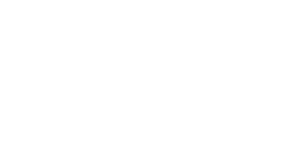

In [5]:
from mpl_toolkits import mplot3d
%matplotlib notebook
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xx,yy,zz, color='red', label='Data')
xe = np.arange(10700, 25000, 1000)
ye = np.arange(24, 30, 0.5)
xxe, yye = np.meshgrid(xe, ye)
fe = np.empty_like(xxe)
for i in range(np.size(fe,0)):
    for j in range(np.size(fe,1)):
        fe[i,j] = f2(xxe[i,j],yye[i,j])
ax.plot_surface(xxe,yye,fe,color='lightblue',alpha=0.75)

plt.title('Comparison of Time and Q on SF')
ax.set_xlabel('$Time (s)$')
ax.set_ylabel('Ion Exchange Capacity $(mol/m^3)$')
ax.set_zlabel('SF')
plt.show()

### From (1) Takahashi et al. (1993) Reference. SEPARATION OF LIGHT RARE-EARTH ELEMENTS FROM RARE-EARTH MIXTURE SOLUTION BY USE OF ELECTRODIALYSIS WITH COMPLEXING AGENTS.

### Attempting to solve the following DE for the REE ions $La^{3+}$ and $Nd^{3+}$:

![](diff_eqn_16.png "picture")

#### Solving Takahashi Model Equations 2-6 Simultaneously

<code>From their paper:</code>

<img src="takahashi_26.png" width="600">

#### Solving Takahashi Model Equations 7-9 Simultaneously

<img src="takahashi_eq79.png" width="600">

__Model Diagram__

<img src="state_machine_takahashi.png" width="750">

## Personal Workbook Notes:

- Biggest problem to overcome is deciding upon how to implement everything.
- Equations 2-9 rely on guess values for fsolve. Can somehow generate intelligent guesses?
- It appears odeint is more receptive than solve_ivp for this implementation.
- The solution to updating input values like concentration and type of REE/chelant was to use update function. THis update function has the nested functions for each segment of the model.
- Still unknown whether computed values are correct or not (lack of reference).
- Overall my biggest adversity with programming is the feeling of being overwhelemd by having to juggle so many functions and consider their input arguments (leading to programmer's block). Debugging is second next.
